# Sensor Data Analysis

Analyse raw sensor data from PhysioNet: https://physionet.org/physiobank/database/noneeg/

Data: "Bag of Sensors"

Feature Extraction
- Statistical
- Continuous
- Spectral

Modeling

## Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pip install wfdb
# See: https://github.com/MIT-LCP/wfdb-python 
import wfdb

# render plots inline
%matplotlib inline

{'record_name': 'Subject10_AccTempEDA', 'n_sig': 5, 'fs': 8, 'counter_freq': None, 'base_counter': None, 'sig_len': 18239, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['ax', 'ay', 'az', 'temp', 'EDA'], 'p_signal': array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       ...,
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject1

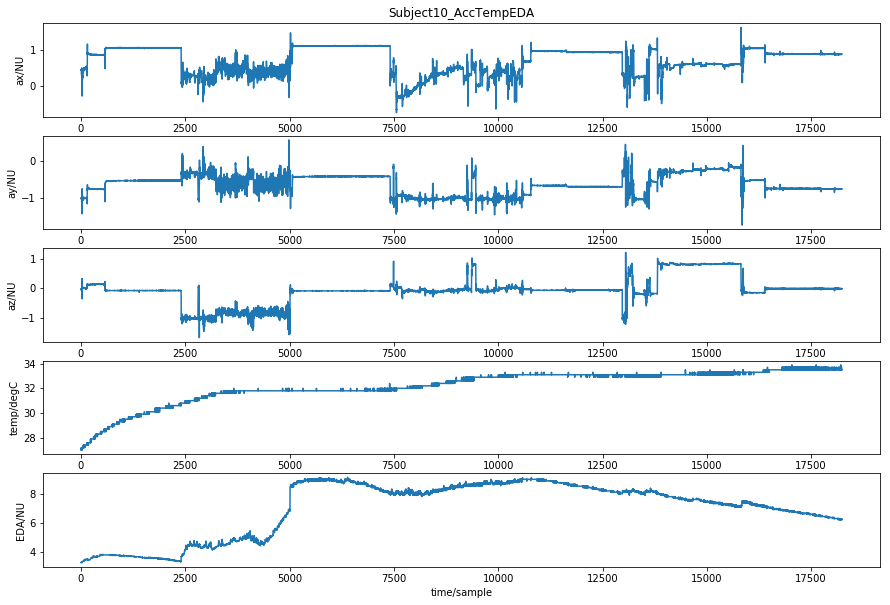

In [2]:
record = wfdb.rdrecord('./data/physionet/Subject10_AccTempEDA')
print(record.__dict__)

wfdb.plot_wfdb(record=record, title='Subject10_AccTempEDA',
              figsize=(15, 10))

In [3]:
data = record.p_signal
data.shape

(18239, 5)

In [4]:
# first 10 rows
data[:10, :]

array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.39992676e-01, -1.00996857e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.00996857e+00, -6.00054933e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -9.99985351e-01, -2.00018311e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -9.99985351e-01, -5.00045778e-02,
         2.72000076e+01,  3.25101413e+00],
       [ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.72000076e+01,  3.25605237e+00],
       [ 4.59979247e-01, -1.00996857e+00, -4.00036622e-02,
         2.72000076e+01

In [5]:
# create dataframe so that we can perform more processing

df = pd.DataFrame(data, columns=[record.sig_name])
df.head()

,ax,ay,az,temp,EDA
0,0.449968,-1.009969,-0.040004,27.000064,3.251014
1,0.439993,-1.019987,-0.040004,27.000064,3.256052
2,0.449968,-1.019987,-0.050005,27.000064,3.256052
3,0.449968,-1.009969,-0.040004,27.000064,3.256052
4,0.439993,-1.009969,-0.050005,27.000064,3.256052


## Statistical Features

In [6]:
df.mean() # mean of each column

ax       0.692899
ay      -0.624442
az      -0.079151
temp    32.179924
EDA      7.020280
dtype: float64

In [10]:
df.median() # median is less sensitive to outliers than mean

ax       0.869974
ay      -0.639988
az      -0.080007
temp    32.599957
EDA      7.809991
dtype: float64

In [7]:
df.std() # standard deviation

ax      0.365214
ay      0.259942
az      0.451252
temp    1.336794
EDA     1.876670
dtype: float64

In [8]:
df.max()

ax       1.619993
ay       0.579982
az       1.219979
temp    33.899959
EDA      9.146924
dtype: float64

In [9]:
df.min()

ax      -0.739971
ay      -1.739982
az      -1.679977
temp    27.000064
EDA      3.251014
dtype: float64

In [21]:
df.columns

MultiIndex(levels=[['EDA', 'ax', 'ay', 'az', 'temp']],
           codes=[[1, 2, 3, 4, 0]])

### Discretise into quantiles

In [24]:
df.ax.values.ravel() # raw values

array([0.44996796, 0.43999268, 0.44996796, ..., 0.87998535, 0.87998535,
       0.87998535])

In [37]:
df['ax_q10'] = pd.qcut(df.ax.values.ravel(), 10, labels=False)

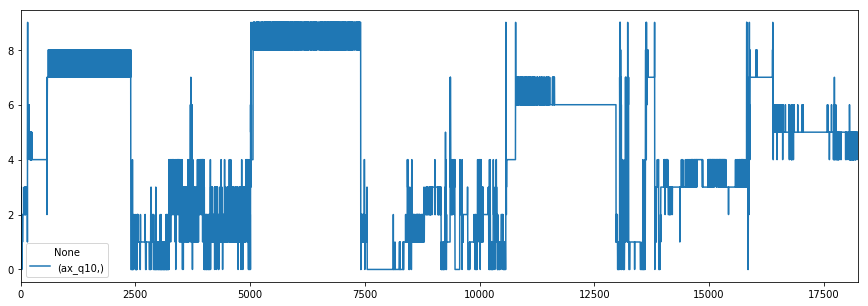

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
df['ax_q10'].plot(ax=ax)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CEF5998C88>]],
      dtype=object)

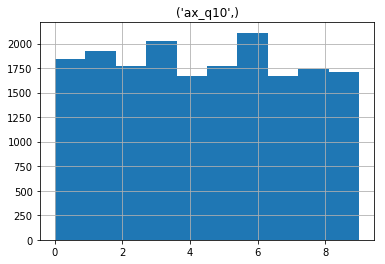

In [39]:
# histogram showing distribution in the 10 levels
df['ax_q10'].hist()